[New Feature Google Colab](https://colab.research.google.com/notebooks/data_table.ipynb#scrollTo=jcQEX_3vHOUz)

##  Logistic Regression Continued

In [1]:
from sklearn import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
import scipy.stats as st
import statsmodels.datasets
%matplotlib inline
sns.set(font_scale=1.5)

In [2]:
bc=pd.read_csv('breast_cancer_scikit_onehot_dataset.csv')
bc.head()
target = bc['class'].map(lambda x: 1 if x == 4 else 0).values 
target = pd.Series(target)
predictor=bc.drop(columns=['class'])

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(predictor, target, test_size=0.3,random_state=9) 

In [4]:
#Create a logistic Classifier
log_reg = LogisticRegression()

#Grid Search
C= np.arange(.000001,2,.01)
parameters = {'penalty':['l1', 'l2'], 'C':C,'class_weight':['balanced']}
clf = GridSearchCV(log_reg, parameters, cv=5,verbose=0)

# Obtain best model
best_model = clf.fit(X_train,y_train)

In [5]:
yprob = best_model.predict_proba(X_test)
yprob[:5]

array([[9.74376176e-01, 2.56238237e-02],
       [1.18828881e-01, 8.81171119e-01],
       [9.36308774e-01, 6.36912264e-02],
       [2.29684756e-04, 9.99770315e-01],
       [9.51196938e-01, 4.88030622e-02]])

### Adjusting Thresholds

- The Logistic Regression gives probability predictions for each class, in addition to the final classification. 
- By default, threshold for the prediction is set to 0.5, but we can adjust that threshold.

In [22]:
predicts = []
for item in best_model.predict_proba(X_test):
    if item[1] >= .25:
        predicts.append(1)
    else:
        predicts.append(0)

In [23]:
from sklearn.metrics import confusion_matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicts),
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,95,6
actual 1,0,70


In [24]:
## accuracy
(conf_matrix['predicted 0'][0] + conf_matrix['predicted 1'][1]) / len(predicts)

0.9649122807017544

### How does this change the Precision, Recall, and F1-Score?

## More Logistic Regression

Probability, odds,log, log-odds

$$probability = \frac {one\ outcome} {all\ outcomes}$$

$$odds = \frac {one\ outcome} {all\ other\ outcomes}$$

Examples:

- Dice roll of 1: probability = 1/6, odds = 1/5


- Even dice roll: probability = 3/6, odds = 3/3 = 1


- Dice roll less than 5: probability = 4/6, odds = 4/2 = 2

$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$

In [25]:
import statsmodels.api as sm

logit = sm.Logit(y_train, X_train)

# fit the model
logit_model = logit.fit()

logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.390705
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  398
Model:                          Logit   Df Residuals:                      389
Method:                           MLE   Df Model:                            8
Date:                Mon, 04 Nov 2019   Pseudo R-squ.:                  0.3946
Time:                        11:16:15   Log-Likelihood:                -155.50
converged:                       True   LL-Null:                       -256.87
                                        LLR p-value:                 1.692e-39
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
clump_thickness                -0.3013      0.074     -4.066      0.000      -0.447      -0.156
uniformity_of_cell_size         0.7766      0.162      4.796      0.000       0.459       1.094
uniformity_of_cell_shape        0.2937      0.143      2.052      0.040       0.013       0.574
marginal_adhesion               0.1837      0.090      2.030      0.042       0.006       0.361
single_epithelial_cell_size    -0.6654      0.121     -5.493      0.000      -0.903      -0.428
bare_nuclei                     0.5732      0.080      7.192      0.000       0.417       0.729
bland_chromatin                -0.6120      0.121     -5.046      0.000      -0.850      -0.374
normal_nucleoli                 0.2044      0.089      2.289      0.022       0.029       0.379
mitosis                        -0.2964      0.102     -2.902      0.004      -0.497      -0.096
===============================================================================================
"""

- Positive coefficients increase the log-odds of the response (and thus increase the probability)
- Negative coefficients decrease the log-odds of the response (and thus decrease the probability).

### Odds Ratio

- **Odds Ratio** is the exponentiated coefficient, and can be interpreted as the multiplicative change in the odds for a one unit change in the predictor variable. 

In [26]:
# odds ratio
np.exp(logit_model.params)

clump_thickness                0.739861
uniformity_of_cell_size        2.174162
uniformity_of_cell_shape       1.341427
marginal_adhesion              1.201661
single_epithelial_cell_size    0.514064
bare_nuclei                    1.773929
bland_chromatin                0.542273
normal_nucleoli                1.226800
mitosis                        0.743492
dtype: float64

In [ ]:
# odds ratios and 95% CI
params = logit_model.params
conf = logit_model.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
np.exp(conf)

## Comparing Logistic Regression with Other Models

Advantages of logistic regression:

- Highly interpretable (if you remember how)
- Model training and prediction are fast
- Not many parameters to tune
- Can perform well with a small number of observations
- Outputs well-calibrated predicted probabilities

Disadvantages of logistic regression:

- Presumes a linear relationship between the features and the log-odds of the response
- Performance is (generally) not competitive with the best supervised learning methods
- Can't automatically learn feature interactions

## 2. Maximum Likelihood
- [MLE Video](https://www.youtube.com/watch?v=XepXtl9YKwc)

- Procedure of finding the value of one or more parameters for a given statistic which makes the known likelihood distribution a maximum. 
- Common way of thinking about optimizing parameters in statistics and machine learning.   
- Conceptually when working with a probabilistic model with **unknown parameters**, the parameters which make the data have the highest probability are the most likely ones.

### Concept

 Suppose we have a model with parameters $\boldsymbol{\theta}$ and a collection of data points $X$.  

We want to find the most likely value for the parameters of our model, that means we want to find

$$
\mathop{\mathrm{argmax}} P(\boldsymbol{\theta}\mid X).
$$

By Bayes' rule, this is the same thing as

$$
\mathop{\mathrm{argmax}} \frac{P(X \mid \boldsymbol{\theta})P(\boldsymbol{\theta})}{P(X)}.
$$

The expression $P(X)$, a parameter agnostic probability of generating the data, does not depend on $\boldsymbol{\theta}$ at all, and so can be dropped without changing the best choice of $\boldsymbol{\theta}$.  Similarly, we may now posit that we have no prior assumption on which set of parameters are better than any others, so we may declare that $P(\boldsymbol{\theta})$ does not depend on theta either!  This, for instance, makes sense in a coin flipping example where the probability a coin comes up heads could be any value in $[0,1]$ without any prior belief it is fair or not (often referred to as an *uninformative prior*).  Thus we see that our application of Bayes' rule shows that our best choice of $\boldsymbol{\theta}$ is the maximum likelihood estimate for $\boldsymbol{\theta}$:

$$
\hat{\boldsymbol{\theta}} = \mathop{\mathrm{argmax}} _ {\boldsymbol{\theta}} P(X \mid \boldsymbol{\theta}).
$$

As a matter of common terminology, the probability of the data given the parameters ($P(X \mid \boldsymbol{\theta})$) is referred to as the *likelihood*.

### Example Exponential Distribution

In [27]:
data = statsmodels.datasets.heart.load_pandas().data

In [28]:
data.tail()

,survival,censors,age
64,14.0,1.0,40.3
65,167.0,0.0,26.7
66,110.0,0.0,23.7
67,13.0,0.0,28.9
68,1.0,0.0,35.2


- A censor of 0 means that the patient was alive at the end of the study, and thus we don't know the exact survival time. We only know that the patient survived at least the indicated number of days.

In [29]:
data = data[data.censors == 1]
survival = data.survival
survival.head()

0     15.0
1      3.0
2    624.0
3     46.0
4    127.0
Name: survival, dtype: float64

### Plot of the Survival Data

Text(0, 0.5, 'Number of patients')

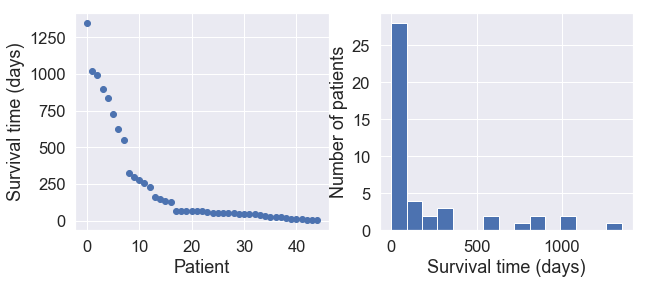

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(sorted(survival)[::-1], 'o')
ax1.set_xlabel('Patient')
ax1.set_ylabel('Survival time (days)')

ax2.hist(survival, bins=15)
ax2.set_xlabel('Survival time (days)')
ax2.set_ylabel('Number of patients')

- Let's try to fit an exponential distribution to the data. 
- According to this model, $S$ (number of days of survival) is an exponential random variable with the parameter $\lambda$ , and the observations ${s_i}$ are sampled from this distribution.

Let's define the sample mean as:
$$\overline s = \frac 1 n \sum s_i$$

The likelihood function of an exponential distribution is as follows, by definition

$$\mathcal{L}(\lambda, \{s_i\}) = P(\{s_i\} \mid \lambda) = \lambda^n \exp\left(-\lambda n \overline s\right)$$

The maximum likelihood estimate for the rate parameter is, by definition, the value ${λ}$ that maximizes the likelihood function. In other words, it is the parameter that maximizes the probability of observing the data, assuming that the observations are sampled from an exponential distribution.

Here, it can be shown that the likelihood function has a maximum value when $λ= \frac{1}{\overline s}$, which is the maximum likelihood estimate for the rate parameter. Let's compute this parameter numerically:

In [37]:
smean = survival.mean()
rate = 1. / smean
smean

223.2888888888889

In [32]:
#To compare the fitted exponential distribution to the data, 
#we first need to generate linearly spaced values for the x-axis (days):
smax = survival.max()
days = np.linspace(0., smax, 1000)
# bin size: interval between two
# consecutive values in `days`
dt = smax / 999.

In [33]:
#We can obtain the probability density function of the exponential distribution with SciPy. 
#The parameter is the scale, the inverse of the estimated rate.
dist_exp = st.expon.pdf(days, scale=1./ rate)

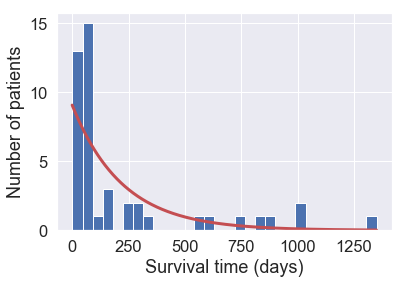

In [34]:
nbins = 30
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(survival, nbins)
ax.plot(days, dist_exp * len(survival) * smax / nbins,
        '-r', lw=3)
ax.set_xlabel("Survival time (days)")
ax.set_ylabel("Number of patients")
plt.show()

- The fit is far from perfect
- We were able to find an analytical formula for the maximum likelihood estimate here. In more complex situations, that is not always possible. 

In [35]:
#Finding numerical maximum likelihood using SciPy
dist = st.expon
args = dist.fit(survival)
args

(1.0, 222.2888888888889)

- We can use these parameters to perform a Kolmogorov-Smirnov test, which assesses the goodness of fit of the distribution with respect to the data. 
- The test is based on a distance between the empirical distribution function of the data and the cumulative distribution function (CDF) of the reference distribution.



In [38]:
st.kstest(survival, dist.cdf, args)

KstestResult(statistic=0.36199693810792966, pvalue=8.647045785208746e-06)

- Here, the p-value is very low: the **null hypothesis** (stating that the observed data stems from an exponential distribution with a maximum likelihood rate parameter) can be rejected with high confidence. 

#### Birnbaum-Sanders Distribution
- Typically used to model failure times.

In [39]:
dist = st.fatiguelife
args = dist.fit(survival)
st.kstest(survival, dist.cdf, args)

KstestResult(statistic=0.1877344610194689, pvalue=0.07321149700086325)

- This time, the p-value is about 0.073, so that we would not reject the null hypothesis with a five percent confidence level. 

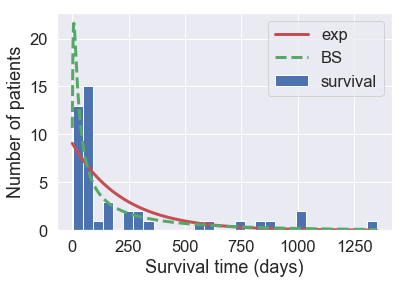

In [40]:
dist_fl = dist.pdf(days, *args)
nbins = 30
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(survival, nbins)
ax.plot(days, dist_exp * len(survival) * smax / nbins,
        '-r', lw=3, label='exp')
ax.plot(days, dist_fl * len(survival) * smax / nbins,
        '--g', lw=3, label='BS')
ax.set_xlabel("Survival time (days)")
ax.set_ylabel("Number of patients")
ax.legend()
plt.show()

## Math Stuff

$$\begin{align*}
\mathcal{L}(\lambda, \{s_i\}) &= P(\{s_i\} \mid \lambda) &\\
&= \prod_{i=1}^n P(s_i \mid \lambda) & \textrm{(by independence of the $s_i$)}\\
&= \prod_{i=1}^n \lambda \exp(-\lambda s_i) &\\
&= \lambda^n \exp\left(-\lambda \sum_{i=1}^n s_i\right) &\\
&= \lambda^n \exp\left(-\lambda n \overline s\right) &
\end{align*}$$

### Find Max Using Derivative

$$\frac{d\mathcal{L}(\lambda, \{s_i\})}{d\lambda} = \lambda^{n-1} \exp\left(-\lambda n \overline s \right) \left( n - n \lambda \overline s \right)$$

$$\lambda = \frac {1}{\overline s}$$